# Non-standard calculations

In this chapter we will consider some non-standard calculations. Some will be useful but need care for practical considerations (*i.e.* transient X-ray spectroscopy), and some are more illustrations of alternative (but not recommended) ways of modelling spectra.


```{note}
- Consider what to have here
- Clean up
```

In [1]:
import copy

import adcc
import gator
import matplotlib.pyplot as plt
import numpy as np
import veloxchem as vlx
from matplotlib import gridspec
from pyscf import cc, dft, gto, mp, scf
from scipy.interpolate import interp1d
from veloxchem.rsplinabscross import LinearAbsorptionCrossSection

# for vlx
silent_ostream = vlx.OutputStream(None)
from mpi4py import MPI

comm = MPI.COMM_WORLD

# au to eV conversion factor
au2ev = 27.211386

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.
* Warning * Setting MKL_THREADING_LAYER to "GNU".


## Transient XAS

### Valence-excited reference state

Can consider low-spin open-shell reference (LSOR) and high-spin open-shell reference (HSOR).

Here an electron from an occupied alpha spin-orbital is promoted to an unoccupied alpha spin-orbital. Note that spin-contaminated by construction, so should perhaps focus on HSOR... Check S2 and so on, consider what would be needed to be spin-pure

In [2]:
water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

mol = gto.Mole()
mol.atom = water_xyz
mol.basis = "6-31G"
mol.build()

# GS
scf_gs = scf.UHF(mol)
scf_gs.kernel()
adc_gs = adcc.cvs_adc2x(scf_gs, n_states=5, core_orbitals=1)

# LSOR
mo0 = copy.deepcopy(scf_gs.mo_coeff)
occ0 = copy.deepcopy(scf_gs.mo_occ)
occ0[0][4] = 0.0
occ0[0][5] = 1.0
scf_es = scf.UHF(mol)
scf.addons.mom_occ(scf_es, mo0, occ0)
scf_es.kernel()
print(27.2114 * (scf_gs.e_tot - scf_es.e_tot))
adc_ls = adcc.cvs_adc2x(scf_es, n_states=5, core_orbitals=1)

# HSOR
mo0 = copy.deepcopy(scf_gs.mo_coeff)
occ0 = copy.deepcopy(scf_gs.mo_occ)
occ0[0][4] = 0.0
occ0[1][5] = 1.0
scf_es = scf.UHF(mol)
scf.addons.mom_occ(scf_es, mo0, occ0)
scf_es.kernel()
print(27.2114 * (scf_gs.e_tot - scf_es.e_tot))
adc_hs = adcc.cvs_adc2x(scf_es, n_states=5, core_orbitals=1)

converged SCF energy = -75.9838703827193  <S^2> = 6.3415939e-12  2S+1 = 1
Starting cvs-adc2x  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8        1.6222  935ms  [20.26123431 20.31992537 20.32302691 20.3464984  20.77599022]
  2    16      0.083151  289ms  [19.71909108 19.74517237 19.78850074 19.81333602 20.43548576]
  3    24     0.0053797  960ms  [19.69205492 19.71929679 19.77413246 19.79760548 20.43133363]
  4    32     0.0011589  529ms  [19.68965835 19.71687333 19.77255677 19.79676938 20.43113845]
  5    40    0.00010183  731ms  [19.68907709 19.71641759 19.7724787  19.79670158 20.43112515]
=== Converged ===
    Number of matrix applies:    40
    Total solver time:             3s 460ms


Overwritten attributes  get_occ  of <class 'pyscf.scf.uhf.UHF'>


converged SCF energy = -75.7142931989804  <S^2> = 1.0127856  2S+1 = 2.2474747
-7.335572577593563
Starting cvs-adc2x  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8        1.4197  779ms  [19.65025265 20.45690115 20.50695083 20.60577589 20.87460994]
  2    16       0.61503  519ms  [19.42062302 19.947623   19.99001099 20.52523445 20.56375323]
  3    24       0.13866  472ms  [19.41668154 19.90410164 19.94479007 20.071764   20.36786149]
  4    32        0.7002  248ms  [19.41628888 19.9008495  19.93986716 20.01129509 20.28160489]
  5    40       0.51076  296ms  [19.41624278 19.90054206 19.93902184 20.00607709 20.0152278 ]
=== Restart ===
  6    16       0.20678  243ms  [19.41623535 19.76616036 19.90050231 19.93894428 20.00537831]
  7    24      0.046603  224ms  [19.41623306 19.6513648  19.90049127 19.93892677 20.00520365]
  8    32     0.0071816  255ms  [19.41623272 19.62621905 19.90048986 19.9389235  20.00515954]
  9    40    0.00053412  306ms  [19.41623268 19.622

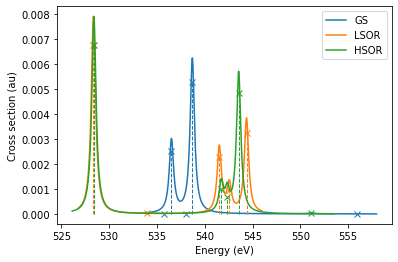

In [3]:
plt.figure()
adc_gs.plot_spectrum(label="GS")
adc_ls.plot_spectrum(label="LSOR")
adc_hs.plot_spectrum(label="HSOR")
plt.legend()
plt.show()

### Coupling

```{note}
To be added
```

## MOM approaches

*Maybe include:* comparing MOM and IMOM (thanks to Anna Kristina and Josefine):

```{note}
Currently just one version.
```

In [4]:
def imom(mf, mocoeffs, occnum):
    """Use initial maximum overlap method to determine occupation number for each orbital in every
    iteration. It can be applied to unrestricted as well as restricted open-shell systems."""

    # Copy initial MO coefficients for occupied orbitals
    # This can be adapted for MOM / IMOM - need to look into
    if isinstance(mf, dft.rks.RKS) or isinstance(mf, scf.hf.RHF):
        coef_occ_a = mocoeffs[:, occnum > 0]
    elif isinstance(mf, dft.uks.UKS) or isinstance(mf, scf.uhf.UHF):
        coef_occ_a = mocoeffs[0][:, occnum[0] > 0]
        coef_occ_b = mocoeffs[1][:, occnum[1] > 0]

    # Write new get_occ routine for DFT kernel
    def get_occ(mo_energy=None, mo_coeff=None):
        # Get new MO energy and coefficients
        if mo_energy is None:
            mo_energy = mf.mo_energy
        if mo_coeff is None:
            mo_coeff = mf.mo_coeff

        # Restricted
        if isinstance(mf, dft.rks.RKS) or isinstance(mf, scf.hf.RHF):
            mo_occ = np.zeros_like(occnum)
            nocc_a = int(np.sum(occnum) / 2)  # number of occupied orbitals

            # Construct s_a = MO_coeff(old)*S*MO_coeff(new)
            SC = np.matmul(mf.get_ovlp().T, mo_coeff)
            s_a = np.matmul(coef_occ_a.T, SC)

            # Get indices for orbitals with largest p = sum_i s_a(ij)s_a(ij)
            idx_a = np.argsort(np.einsum("ij,ij->j", s_a, s_a))[::-1]

            # Set occupation for selected MOs
            mo_occ[idx_a[:nocc_a]] = 2.0

        elif isinstance(mf, dft.uks.UKS) or isinstance(mf, scf.uhf.UHF):
            mo_occ = np.zeros_like(occnum)
            nocc_a = int(np.sum(occnum[0]))  # number of occupied alpha orbitals
            nocc_b = int(np.sum(occnum[1]))  # number of occupied beta orbitals

            # Construct s_a = MO_coeff(old)*S*MO_coeff(new)
            SC_a = np.matmul(mf.get_ovlp().T, mo_coeff[0])
            s_a = np.matmul(coef_occ_a.T, SC_a)
            # Likewise for s_b
            SC_b = np.matmul(mf.get_ovlp().T, mo_coeff[1])
            s_b = np.matmul(coef_occ_b.T, SC_b)

            # Get indices for orbitals with largest p_a = sum_i s_a(ij)s_a(ij)
            idx_a = np.argsort(np.einsum("ij,ij->j", s_a, s_a))[::-1]
            # Likewise for p_b
            idx_b = np.argsort(np.einsum("ij,ij->j", s_b, s_b))[::-1]

            # Set occupation for selected MOs
            mo_occ[0][idx_a[:nocc_a]] = 1.0
            mo_occ[1][idx_b[:nocc_b]] = 1.0

        return mo_occ

    # Redefine get_occ for DFT kernel as new function
    mf.get_occ = get_occ

    return mf

Example: single and double ionization energy of water.

In [5]:
water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Create molecule object
mol = gto.Mole()
mol.atom = water_xyz
mol.basis = "STO-3G"
mol.build()

# Index of core MO
core = 0

# Initial restricted/unrestricted SCF
dft_re = dft.RKS(mol)
dft_re.xc = "b3lyp"
dft_re.kernel()
dft_ur = dft.UKS(mol)
dft_ur.xc = "b3lyp"
dft_ur.kernel()

# Single ionization energy
mo0 = copy.deepcopy(dft_ur.mo_coeff)
occ0 = copy.deepcopy(dft_ur.mo_occ)
occ0[0][core] = 0.0
dft_ion = dft.UKS(mol)
dft_ion.xc = "b3lyp"
imom(dft_ion, mo0, occ0)
dft_ion.kernel()
print(
    "Single ionization energy:",
    np.around(au2ev * (dft_ion.energy_tot() - dft_ur.energy_tot()), 2),
    "eV",
)

# Double ionization energy
mo0 = copy.deepcopy(dft_re.mo_coeff)
occ0 = copy.deepcopy(dft_re.mo_occ)
occ0[core] = 0.0
dft_ion = dft.RKS(mol)
dft_ion.xc = "b3lyp"
imom(dft_ion, mo0, occ0)
dft_ion.kernel()
print(
    "Double ionization energy:",
    np.around(au2ev * (dft_ion.energy_tot() - dft_ur.energy_tot()), 2),
    "eV",
)

converged SCF energy = -75.2761808865589
converged SCF energy = -75.2761808866238  <S^2> = 4.4408921e-15  2S+1 = 1


Overwritten attributes  get_occ  of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -55.3337590090957  <S^2> = 0.7505567  2S+1 = 2.0005566
Single ionization energy: 542.66 eV


Overwritten attributes  get_occ  of <class 'pyscf.dft.rks.RKS'>


converged SCF energy = -31.2166877507322
Double ionization energy: 1198.92 eV


Can compare these values to experiment *etc*.

(sec:xray_cvs_vs_full)=
## Full space vs CVS

In order to illustrate the restricted channel/CVS scheme in TDDFT, we here diagonalize the full-space and CVS-space matrices and compare the resulting spectra.

### Full-space


The linear response function for TDDFT (in TDHF also known as random phase approximation (RPA)), which can be written as

$$
\langle\langle \hat{\mu}_\alpha; \hat{V} \rangle\rangle_\omega =
-{\mu^{[1]}}^\dagger
\Big(
E^{[2]} - \omega S^{[2]}
\Big)^{-1}
V^{[1]},
$$

with $E^{[2]}$ being the electronic Hessian, $\omega$, being the excitation energies and $S^{[2]}$ being the overlap matrix. ${\mu^{[1]}}$ and $V^{[1]}$ are denoted the property gradients. The electronic Hessian, overlap matrix, and property gradient takes the formes:

$$
E^{[2]} = \left(\begin{matrix}
A  &  B \\
B^* &  A\\
\end{matrix}\right),
\qquad
S^{[2]} = \left(\begin{matrix}
1  &  0 \\
1 &  -1\\
\end{matrix}\right),
\qquad
V^{[1]} = \left(\begin{matrix}
g   \\
g^* \\
\end{matrix}\right).
$$
The excitation energies can be determined as the poles of the polarization propagator, i.e. $
\Big(E^{[2]} - \omega S^{[2]}\Big) = 0$, and thus to obtain these, we solve the eigenvalue problem

$$
E^{[2]}X = {\lambda} S^{[2]}X 
$$

where

$$
{\lambda} =\begin{pmatrix}
\lambda & 0\\
0 & -\lambda
\end{pmatrix}
$$

By rewriting the linear response equation, we can identify the transition moment as $X_n^{\dagger}V_{\beta}^{[1]}$, and obtain the oscillator strength as:

$$
(T^{\mu})^{2} = \sum_{\beta=x,y,z}{\mu_{\beta}^{[1]}}^\dagger X_n X_n^{\dagger}\mu_{\beta}^{[1]}\\
f_{osc}^{if} = \frac{2}{3}\cdot \omega_{if}\cdot(T^{\mu})^2
$$

In [6]:
water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""
basis = "sto-3g"
vlx_mol = vlx.Molecule.read_str(water_xyz, units="angstrom")
vlx_bas = vlx.MolecularBasis.read(vlx_mol, basis)

scf_drv = vlx.ScfRestrictedDriver()
scf_settings = {"conv_thresh": 1.0e-6}
method_settings = {"xcfun": "b3lyp"}
scf_drv.update_settings(scf_settings, method_settings)
scf_drv.compute(vlx_mol, vlx_bas)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Kohn-Sham                                            
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

Loading Hessian and property gradients and constructing overlap matrix:

In [7]:
lrs = vlx.LinearResponseEigenSolver()
lrs.update_settings(scf_settings, method_settings)
rsp_drv = vlx.LinearResponseSolver()
rsp_drv.update_settings(scf_settings, method_settings)

# Electronic Hessian
E2 = lrs.get_e2(vlx_mol, vlx_bas, scf_drv.scf_tensors)

# Property gradients for dipole operator
V1_x = rsp_drv.get_prop_grad(
    "electric dipole", "x", vlx_mol, vlx_bas, scf_drv.scf_tensors
)[0]
V1_y = rsp_drv.get_prop_grad(
    "electric dipole", "y", vlx_mol, vlx_bas, scf_drv.scf_tensors
)[0]
V1_z = rsp_drv.get_prop_grad(
    "electric dipole", "z", vlx_mol, vlx_bas, scf_drv.scf_tensors
)[0]

# Dimension
c = int(len(E2) / 2)

# Overlap matrix
S2 = np.identity(2 * c)
S2[c : 2 * c, c : 2 * c] *= -1

* Info * Molecular grid with 35950 points generated in 0.01 sec.                                                          
                                                                                                                          
* Info * Processing Fock builds... (batch size: 40)                                                                       
* Info *   batch 1/1                                                                                                      


In [8]:
## Full diagonalization

# Set up and solve eigenvalue problem
Sinv = np.linalg.inv(S2)  # for clarity - is identical
M = np.matmul(Sinv, E2)
eigs, X = np.linalg.eig(M)

# Reorder results
idx = np.argsort(eigs)
eigs = np.array(eigs)[idx]
X = np.array(X)[:, idx]

# Compute oscillator strengths
fosc = []
for i in range(int(len(eigs) / 2)):
    j = i + int(len(eigs) / 2)  # focus on excitations
    Xf = X[:, j]
    Xf = Xf / np.sqrt(np.matmul(Xf.T, np.matmul(S2, Xf)))
    tm = np.dot(Xf, V1_x) ** 2 + np.dot(Xf, V1_y) ** 2 + np.dot(Xf, V1_z) ** 2
    fosc.append(tm * 2.0 / 3.0 * eigs[j])

In [9]:
au2ev = 27.211396

print(f"Energy/eV    Osc. strength")
print(f"---------------------------")
for i in range(int(len(eigs) / 2)):
    j = i + int(len(eigs) / 2)  # focus on excitations
    print(f" {au2ev*eigs[j] : .2f}        {fosc[i] : .5f}")
print(f"---------------------------")

Energy/eV    Osc. strength
---------------------------
  11.57         0.00230
  13.86         0.00000
  14.45         0.06403
  17.77         0.05891
  21.44         0.94532
  26.74         0.42522
  36.77         0.14154
  36.91         0.05850
  519.02         0.05384
  521.26         0.08679
---------------------------


### CVS space

In [10]:
## Indices and dimensions

# VUmber of virtuals
nocc = vlx_mol.number_of_alpha_electrons()
nvirt = vlx.MolecularBasis.get_dimensions_of_basis(vlx_bas, vlx_mol) - nocc
n = nocc * nvirt

# CVS space
res_mo = 1
res_indx = 0
c = res_mo * nvirt

In [11]:
## Construct CVS objects

# Define starting index for deexcitation
c_int_deex = n + res_indx

# CVS Hessian
E2_cvs = np.zeros((2 * c, 2 * c))
E2_cvs[0:c, 0:c] = E2[res_indx:c, res_indx:c]
E2_cvs[0:c, c : 2 * c] = E2[res_indx:c, c_int_deex : c_int_deex + c]
E2_cvs[c : 2 * c, 0:c] = E2[c_int_deex : c_int_deex + c, res_indx:c]
E2_cvs[c : 2 * c, c : 2 * c] = E2[
    c_int_deex : c_int_deex + c, c_int_deex : c_int_deex + c
]

# CVS overlap matrix
S2_cvs = np.identity(2 * c)
S2_cvs[c : 2 * c, c : 2 * c] *= -1

# CVS property gradients
V1_cvs_x = np.zeros(2 * c)
V1_cvs_x[0:c] = V1_x[res_indx:c]
V1_cvs_x[c : 2 * c] = V1_x[c_int_deex : c_int_deex + c]
V1_cvs_y = np.zeros(2 * c)
V1_cvs_y[0:c] = V1_y[res_indx:c]
V1_cvs_y[c : 2 * c] = V1_y[c_int_deex : c_int_deex + c]
V1_cvs_z = np.zeros(2 * c)
V1_cvs_z[0:c] = V1_z[res_indx:c]
V1_cvs_z[c : 2 * c] = V1_z[c_int_deex : c_int_deex + c]

In [12]:
## Full diagonalization in CVS space

# Set up and solve eigenvalue problem
Sinv = np.linalg.inv(S2_cvs)  # for clarity - is identical
M = np.matmul(Sinv, E2_cvs)
eigs_cvs, X_cvs = np.linalg.eig(M)

# Reorder results
idx = np.argsort(eigs_cvs)
eigs_cvs = np.array(eigs_cvs)[idx]
X_cvs = np.array(X_cvs)[:, idx]

# Compute oscillator strengths
fosc_cvs = []
for i in range(int(len(eigs_cvs) / 2)):
    j = i + int(len(eigs_cvs) / 2)  # focus on excitations
    Xf_cvs = X_cvs[:, j]
    Xf_cvs = Xf_cvs / np.sqrt(np.matmul(Xf_cvs.T, np.matmul(S2_cvs, Xf_cvs)))
    tm_cvs = (
        np.dot(Xf_cvs, V1_cvs_x) ** 2
        + np.dot(Xf_cvs, V1_cvs_y) ** 2
        + np.dot(Xf_cvs, V1_cvs_z) ** 2
    )
    fosc_cvs.append(tm_cvs * 2.0 / 3.0 * eigs_cvs[j])

In [13]:
## Print and plot results

au2ev = 27.211396

print(f"Energy/eV    Osc. strength")
print(f"---------------------------")
for i in range(int(len(eigs_cvs) / 2)):
    j = i + int(len(eigs_cvs) / 2)  # focus on excitations
    print(f" {au2ev*eigs_cvs[j] : .2f}        {fosc_cvs[i] : .5f}")
print(f"---------------------------")

Energy/eV    Osc. strength
---------------------------
  519.02         0.05339
  521.26         0.08609
---------------------------


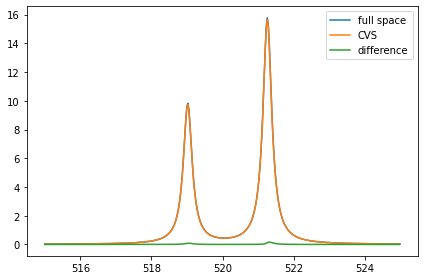

In [14]:
# Plot both sets


def lorentzian(x, y, xmin, xmax, xstep, gamma):
    xi = np.arange(xmin, xmax, xstep)
    yi = np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)):
            yi[i] = yi[i] + y[k] * (gamma / 2.0) / (
                (xi[i] - x[k]) ** 2 + (gamma / 2.0) ** 2
            )
    return xi, yi


plt.figure()
x, y = eigs[int(len(eigs) / 2) :], fosc
x1, y1 = lorentzian(x, y, 515 / au2ev, 525 / au2ev, 0.001, 0.3 / au2ev)
plt.plot(x1 * au2ev, y1)
x, y = eigs_cvs[int(len(eigs_cvs) / 2) :], fosc_cvs
x2, y2 = lorentzian(x, y, 515 / au2ev, 525 / au2ev, 0.001, 0.3 / au2ev)
plt.plot(x2 * au2ev, y2)
plt.plot(x2 * au2ev, y1 - y2)
plt.legend(("full space", "CVS", "difference"))

plt.tight_layout()
plt.show()

```{note}
To be added: comparison to CVS functionalities in `VeloxChem` (currently unavailable).
```

(sec:xray_ie_diffuse)=
## Ionization energies from XAS

Using diffuse basis function. Spectra and IE.

```{note}
To be added.
```

## Ionization energies from XES

Using diffuse basis function. IE.

```{note}
To be added.
```

## XES in reverse

The XES process can like the XAS process be considered in reverse and thus calculated from core excitation of a valence ionized state, rather than from valence deexcitations of a core ionized state.

In [15]:
xes_rev_E = []
xes_rev_f = []

# Perform unrestricted SCF calculation
scf_res = scf.UHF(mol)
scf_res.kernel()

# Copy molecular orbital coefficients
mo0 = copy.deepcopy(scf_res.mo_coeff)

for i in range(4):
    occ0 = copy.deepcopy(scf_res.mo_occ)
    occ0[0][4 - i] = 0.0
    # Perform unrestricted SCF calculation with MOM constraint
    scf_ion = scf.UHF(mol)
    scf.addons.mom_occ(scf_ion, mo0, occ0)
    scf_ion.kernel()
    # Perform ADC calculation of first four states
    adc_xes = adcc.cvs_adc2(scf_ion, n_states=1, core_orbitals=1)
    xes_rev_E.append(au2ev * adc_xes.excitation_energy)
    xes_rev_f.append(adc_xes.oscillator_strength)

converged SCF energy = -74.9635132992207  <S^2> = 3.1334935e-12  2S+1 = 1
converged SCF energy = -74.6571057626323  <S^2> = 0.75528744  2S+1 = 2.0052805
Starting cvs-adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     3       0.13803   1.7s  [19.68772049]
  2     6    6.4422e-07  198ms  [19.63606684]
=== Converged ===
    Number of matrix applies:    6
    Total solver time:             1s 863ms
converged SCF energy = -74.5728036635441  <S^2> = 0.75074736  2S+1 = 2.0007472
Starting cvs-adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     3       0.14382   1.8s  [19.60198384]
  2     6    1.8609e-06  107ms  [19.54756653]
=== Converged ===
    Number of matrix applies:    6
    Total solver time:             1s 880ms
converged SCF energy = -74.372398836201  <S^2> = 0.75404846  2S+1 = 2.0040444
Starting cvs-adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     3       0.38131   1.2s  [19.5474759]
  2     6      0.0

In [16]:
# From a core-hole

occ0 = copy.deepcopy(scf_res.mo_occ)
occ0[0][0] = 0.0

scf_ion = scf.UHF(mol)
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()
adc_xes = adcc.adc2(scf_ion, n_states=4)
xes_E = -au2ev * adc_xes.excitation_energy
xes_f = adc_xes.oscillator_strength

converged SCF energy = -55.0578426854961  <S^2> = 0.75156609  2S+1 = 2.0015655
Starting adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8       0.17337   1.4s  [-19.51438283 -19.42928246 -19.20529078 -18.57317527]
  2    16    5.8712e-05  152ms  [-19.55996768 -19.47432374 -19.25374075 -18.63244417]
=== Converged ===
    Number of matrix applies:    16
    Total solver time:             1s 526ms



Excitation Energy/eV     Osc. strength
-------------------------------------------
    532.25                    0.053868
    532.25                    0.053868
    532.25                    0.053868
    532.25                    0.053868
-------------------------------------------

Excitation Energy/eV     Osc. strength
-------------------------------------------
    534.32                    0.050481
    531.92                    0.039291
    526.64                    0.032744
    509.98                    0.003519
-------------------------------------------


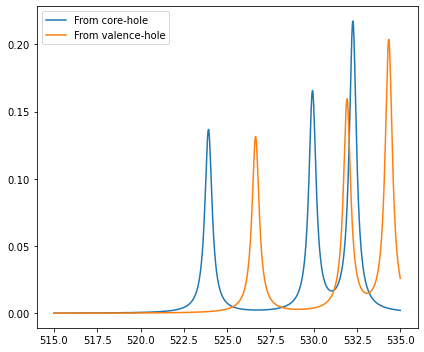

In [17]:
print(f"\nExcitation Energy/eV     Osc. strength")
print(f"-------------------------------------------")
for i in range(len(xes_E)):
    print(f"   {xes_E[0] : .2f}                   {xes_f[0] : .6f}")
print(f"-------------------------------------------")

print(f"\nExcitation Energy/eV     Osc. strength")
print(f"-------------------------------------------")
for i in range(len(xes_rev_E)):
    print(f"   {xes_rev_E[i][0] : .2f}                   {xes_rev_f[i][0] : .6f}")
print(f"-------------------------------------------")

# Plot
plt.figure(figsize=(6, 5))
x, y = xes_E, xes_f
xi, yi = lorentzian(x, y, 515, 535, 0.01, 0.5)
plt.plot(xi, yi)
x, y = xes_rev_E, xes_rev_f
xi, yi = lorentzian(x, y, 515, 535, 0.01, 0.5)
plt.plot(xi, yi)
plt.legend(("From core-hole", "From valence-hole"))
plt.tight_layout()
plt.show()